# Numerical Variable Analysis

In [1]:
import pandas as pd
import plotly.express as ex
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("Cleansing the data/result clean data.xlsx")

In [3]:
df.dtypes.value_counts()

float64           26
object            18
int64              5
datetime64[ns]     1
dtype: int64

In [4]:
non_category_columns = [x for x in df.columns if df[x].dtypes != 'O']
non_category_columns.remove('Au date')

date_column = [x for x in df.columns if df[x].dtypes == "datetime64[ns]"] 

columns_to_remove = [x for x in non_category_columns if df[x].value_counts().count() < 8]
columns_to_remove.remove('15_Daily_Output')
columns_to_remove.remove('15__TPR_20,10')
columns_to_remove.append('Audit_ID')
columns_to_remove.append('Case:')

numerical_columns = [x for x in non_category_columns if x not in columns_to_remove]
numerical_columns

['6_k_user',
 '10_k_user',
 '15_k_user',
 '18_k_user',
 '6FFF_k_user',
 '10FFF_k_user',
 '6_Daily_Output',
 '10_Daily_Output',
 '15_Daily_Output',
 '18_Daily_Output',
 '6FFF_Daily_Output',
 '10FFF_Daily_Output',
 '6__TPR_20,10',
 '10__TPR_20,10',
 '15__TPR_20,10',
 '18__TPR_20,10',
 '6FFF__TPR_20,10',
 '10FFF__TPR_20,10',
 'predictedValue']

## Missing values in each column

In [5]:
missing_count = df[numerical_columns].isna().sum()
missing_count = missing_count.sort_values(ascending = False)

missing_percent = (df[numerical_columns].isna().sum() / df[numerical_columns].shape[0]) * 100
missing_percent = missing_percent.sort_values(ascending = False)

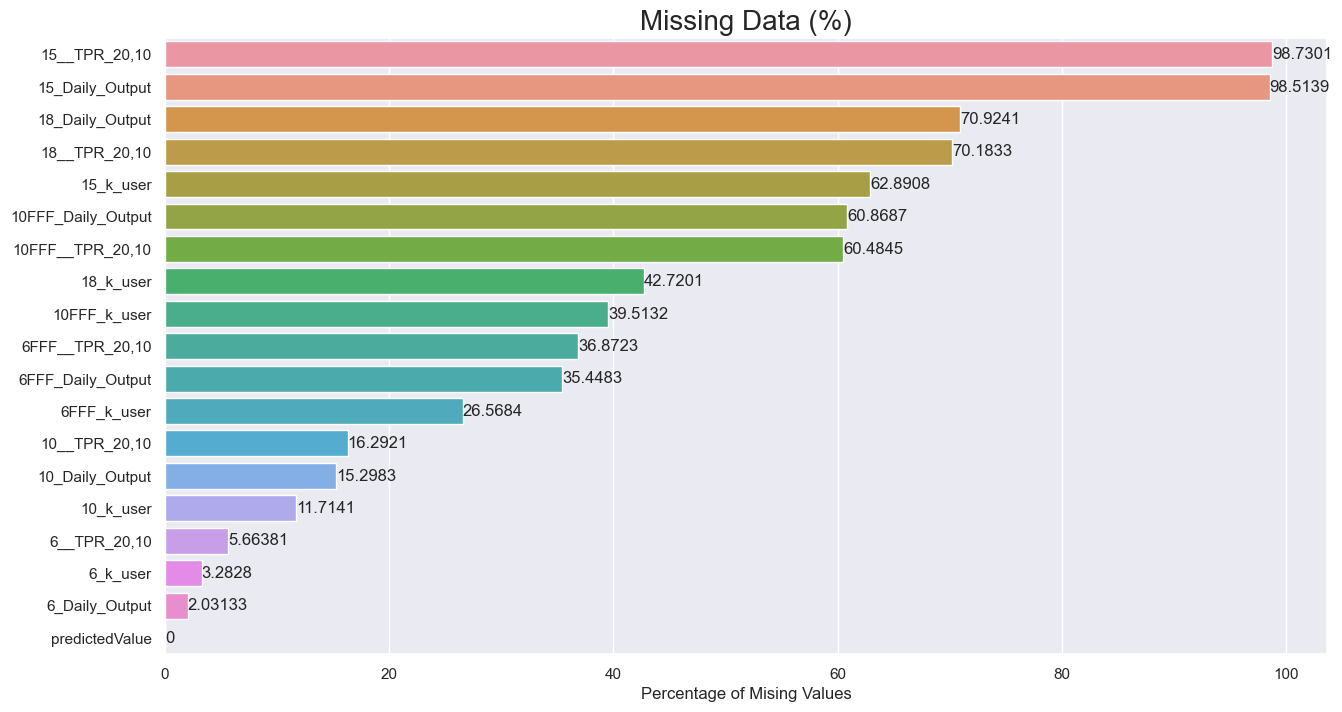

<Figure size 1500x800 with 0 Axes>

In [210]:
sns.set(rc={'figure.figsize':(15,8)})

ax = sns.barplot(y = missing_percent.index, x = missing_percent.values, orient='h')
ax.set(xlabel="Percentage of Mising Values", yticklabels=missing_percent.index)
ax.set_title("Missing Data (%)", size = 20)
sns.set_theme(style = "white")
for i in ax.containers:
    ax.bar_label(i,)
    
plt.show()
plt.savefig("Figures/Missing Data.png")

In [7]:
numerical_columns

['6_k_user',
 '10_k_user',
 '15_k_user',
 '18_k_user',
 '6FFF_k_user',
 '10FFF_k_user',
 '6_Daily_Output',
 '10_Daily_Output',
 '15_Daily_Output',
 '18_Daily_Output',
 '6FFF_Daily_Output',
 '10FFF_Daily_Output',
 '6__TPR_20,10',
 '10__TPR_20,10',
 '15__TPR_20,10',
 '18__TPR_20,10',
 '6FFF__TPR_20,10',
 '10FFF__TPR_20,10',
 'predictedValue']

In [8]:
# Columns with more than 35% missing values
numerical_columns =  [name for name, value in zip(missing_percent.index, missing_percent.values) if value <= 35]

In [9]:
print(f"Total number of features to be included in the numerical analysis: {len(numerical_columns)}\n")
for col in df[numerical_columns].columns:
    print(col)

Total number of features to be included in the numerical analysis: 8

6FFF_k_user
10__TPR_20,10
10_Daily_Output
10_k_user
6__TPR_20,10
6_k_user
6_Daily_Output
predictedValue


## Distributions of each feature

In [10]:
from matplotlib.colors import hsv_to_rgb

In [11]:
"C" + "1"

'C1'

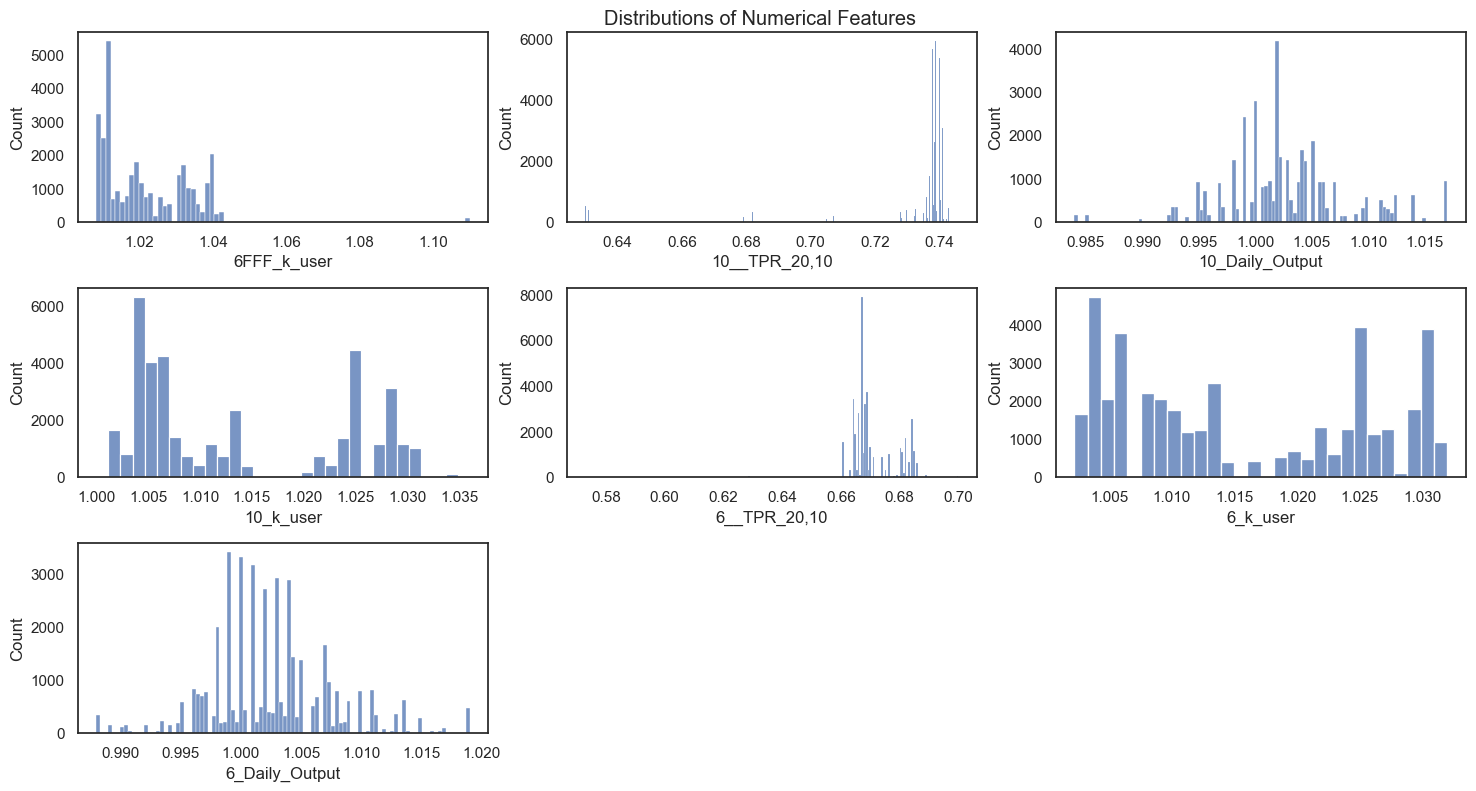

<Figure size 1500x800 with 0 Axes>

In [211]:
# rows = 7
# cols = 3

rows = 3
cols = 3
num_filled_cells = len(numerical_columns)-1 #7

fig, ax = plt.subplots(ncols = cols, nrows=rows, squeeze= False, figsize = (15,8))
fig.tight_layout(pad=2)
for i in range(num_filled_cells):
    row = i//cols
    col = i%cols
    sns.histplot(df[numerical_columns[i]], ax = ax[row, col], color = "C0")
    
fig.suptitle("Distributions of Numerical Features")
    
ax[2,2].set_axis_off()
ax[2,1].set_axis_off()

plt.show()
plt.savefig("Figures/Distributions of Numerical Features.png")

## Ranges and Potential Outliers

In [214]:
cols = sns.color_palette("Spectral",8)
cols

[(0.8472126105344099, 0.2612072279892349, 0.30519031141868513),
 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9977700884275279, 0.930872741253364, 0.6330642060745867),
 (0.944252210688197, 0.9777008842752788, 0.6620530565167244),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.4530565167243369, 0.7815455594002307, 0.6462898885044214),
 (0.21607074202229912, 0.5556324490580546, 0.7319492502883507)]

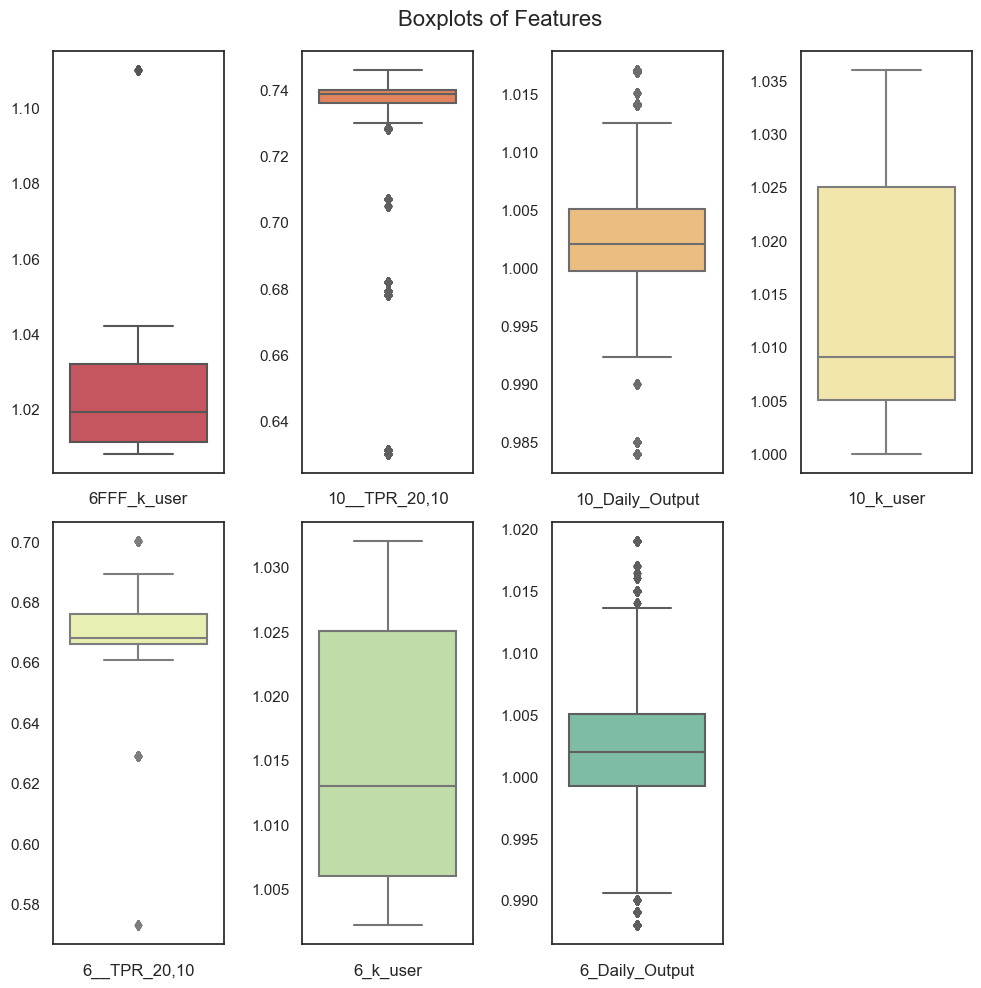

<Figure size 1500x800 with 0 Axes>

In [215]:
fig, ax = plt.subplots(nrows=2, ncols=4, squeeze= True, figsize = (10,10))
fig.suptitle("Boxplots of Features", fontsize = 16)
fig.tight_layout(w_pad=2, h_pad=1)

for i in range(len(numerical_columns[:-1])):
    row = i//4
    column = i%4
    p = sns.boxplot(df[numerical_columns[i]], ax = ax[row,column], color=cols[i])
    p.set(xlabel=numerical_columns[i])
    p.set(xticklabels="")
    
ax[1,3].set_axis_off()
# ax[2,1].set_axis_off()
plt.show()
plt.savefig("Figures/Boxplots of Features.png")

## Plotting number of audits over time

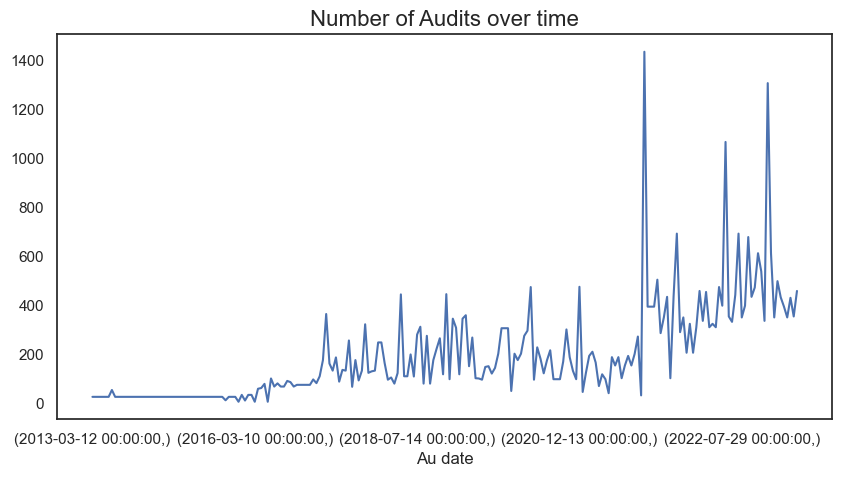

In [90]:
dates = df[date_column].value_counts().sort_index()
dates.plot(figsize = (10,5))
plt.title("Number of Audits over time", fontsize = 16)
plt.show()

## Heatmap of numerical data

In [17]:
df["predictedValue"]

0          -0.011864
1          -0.008924
2          -0.013807
3          -0.011913
4          -0.013800
            ...     
43464    1206.000000
43465     960.000000
43466     700.000000
43467    1014.000000
43468    1303.000000
Name: predictedValue, Length: 43469, dtype: float64

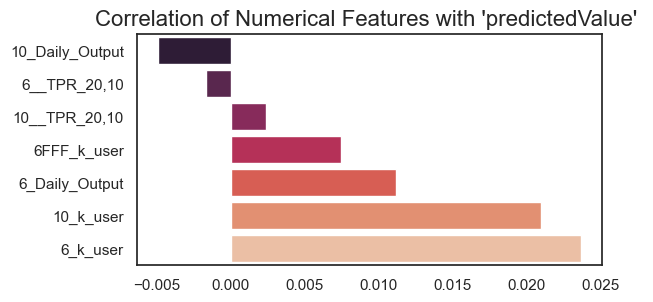

<Figure size 1500x800 with 0 Axes>

In [216]:
corr_data = df[numerical_columns[:-1]].corrwith(df["predictedValue"]).sort_values()

fig, ax = plt.subplots(figsize = (6,3))
sns.barplot(y = corr_data.index,  x = corr_data.values, orient='h', palette='rocket', ax = ax)

plt.title("Correlation of Numerical Features with 'predictedValue' ", fontsize = 16)
plt.show()
plt.savefig("Figures/Correlation of each of the numerical features.png")

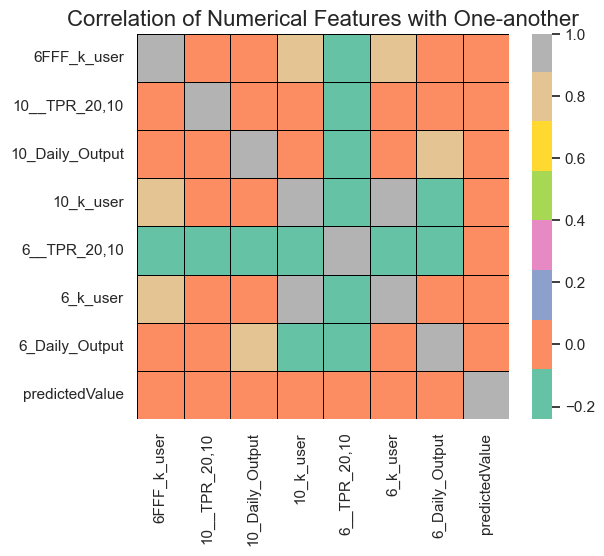

<Figure size 1500x800 with 0 Axes>

In [217]:
fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches

sns.heatmap(df[numerical_columns].corr(),linewidths=0.5, linecolor='black', ax=ax, center = 0.4, cmap = ("Set2"))
plt.title("Correlation of Numerical Features with One-another", size = 16)
plt.show()
plt.savefig("Figures/Correlation Numerical Features with one another.png")

In [127]:
per_case_manuf_values = df[["Manuf","predictedValue","Case:"]].groupby(["Case:","Manuf"]).median()

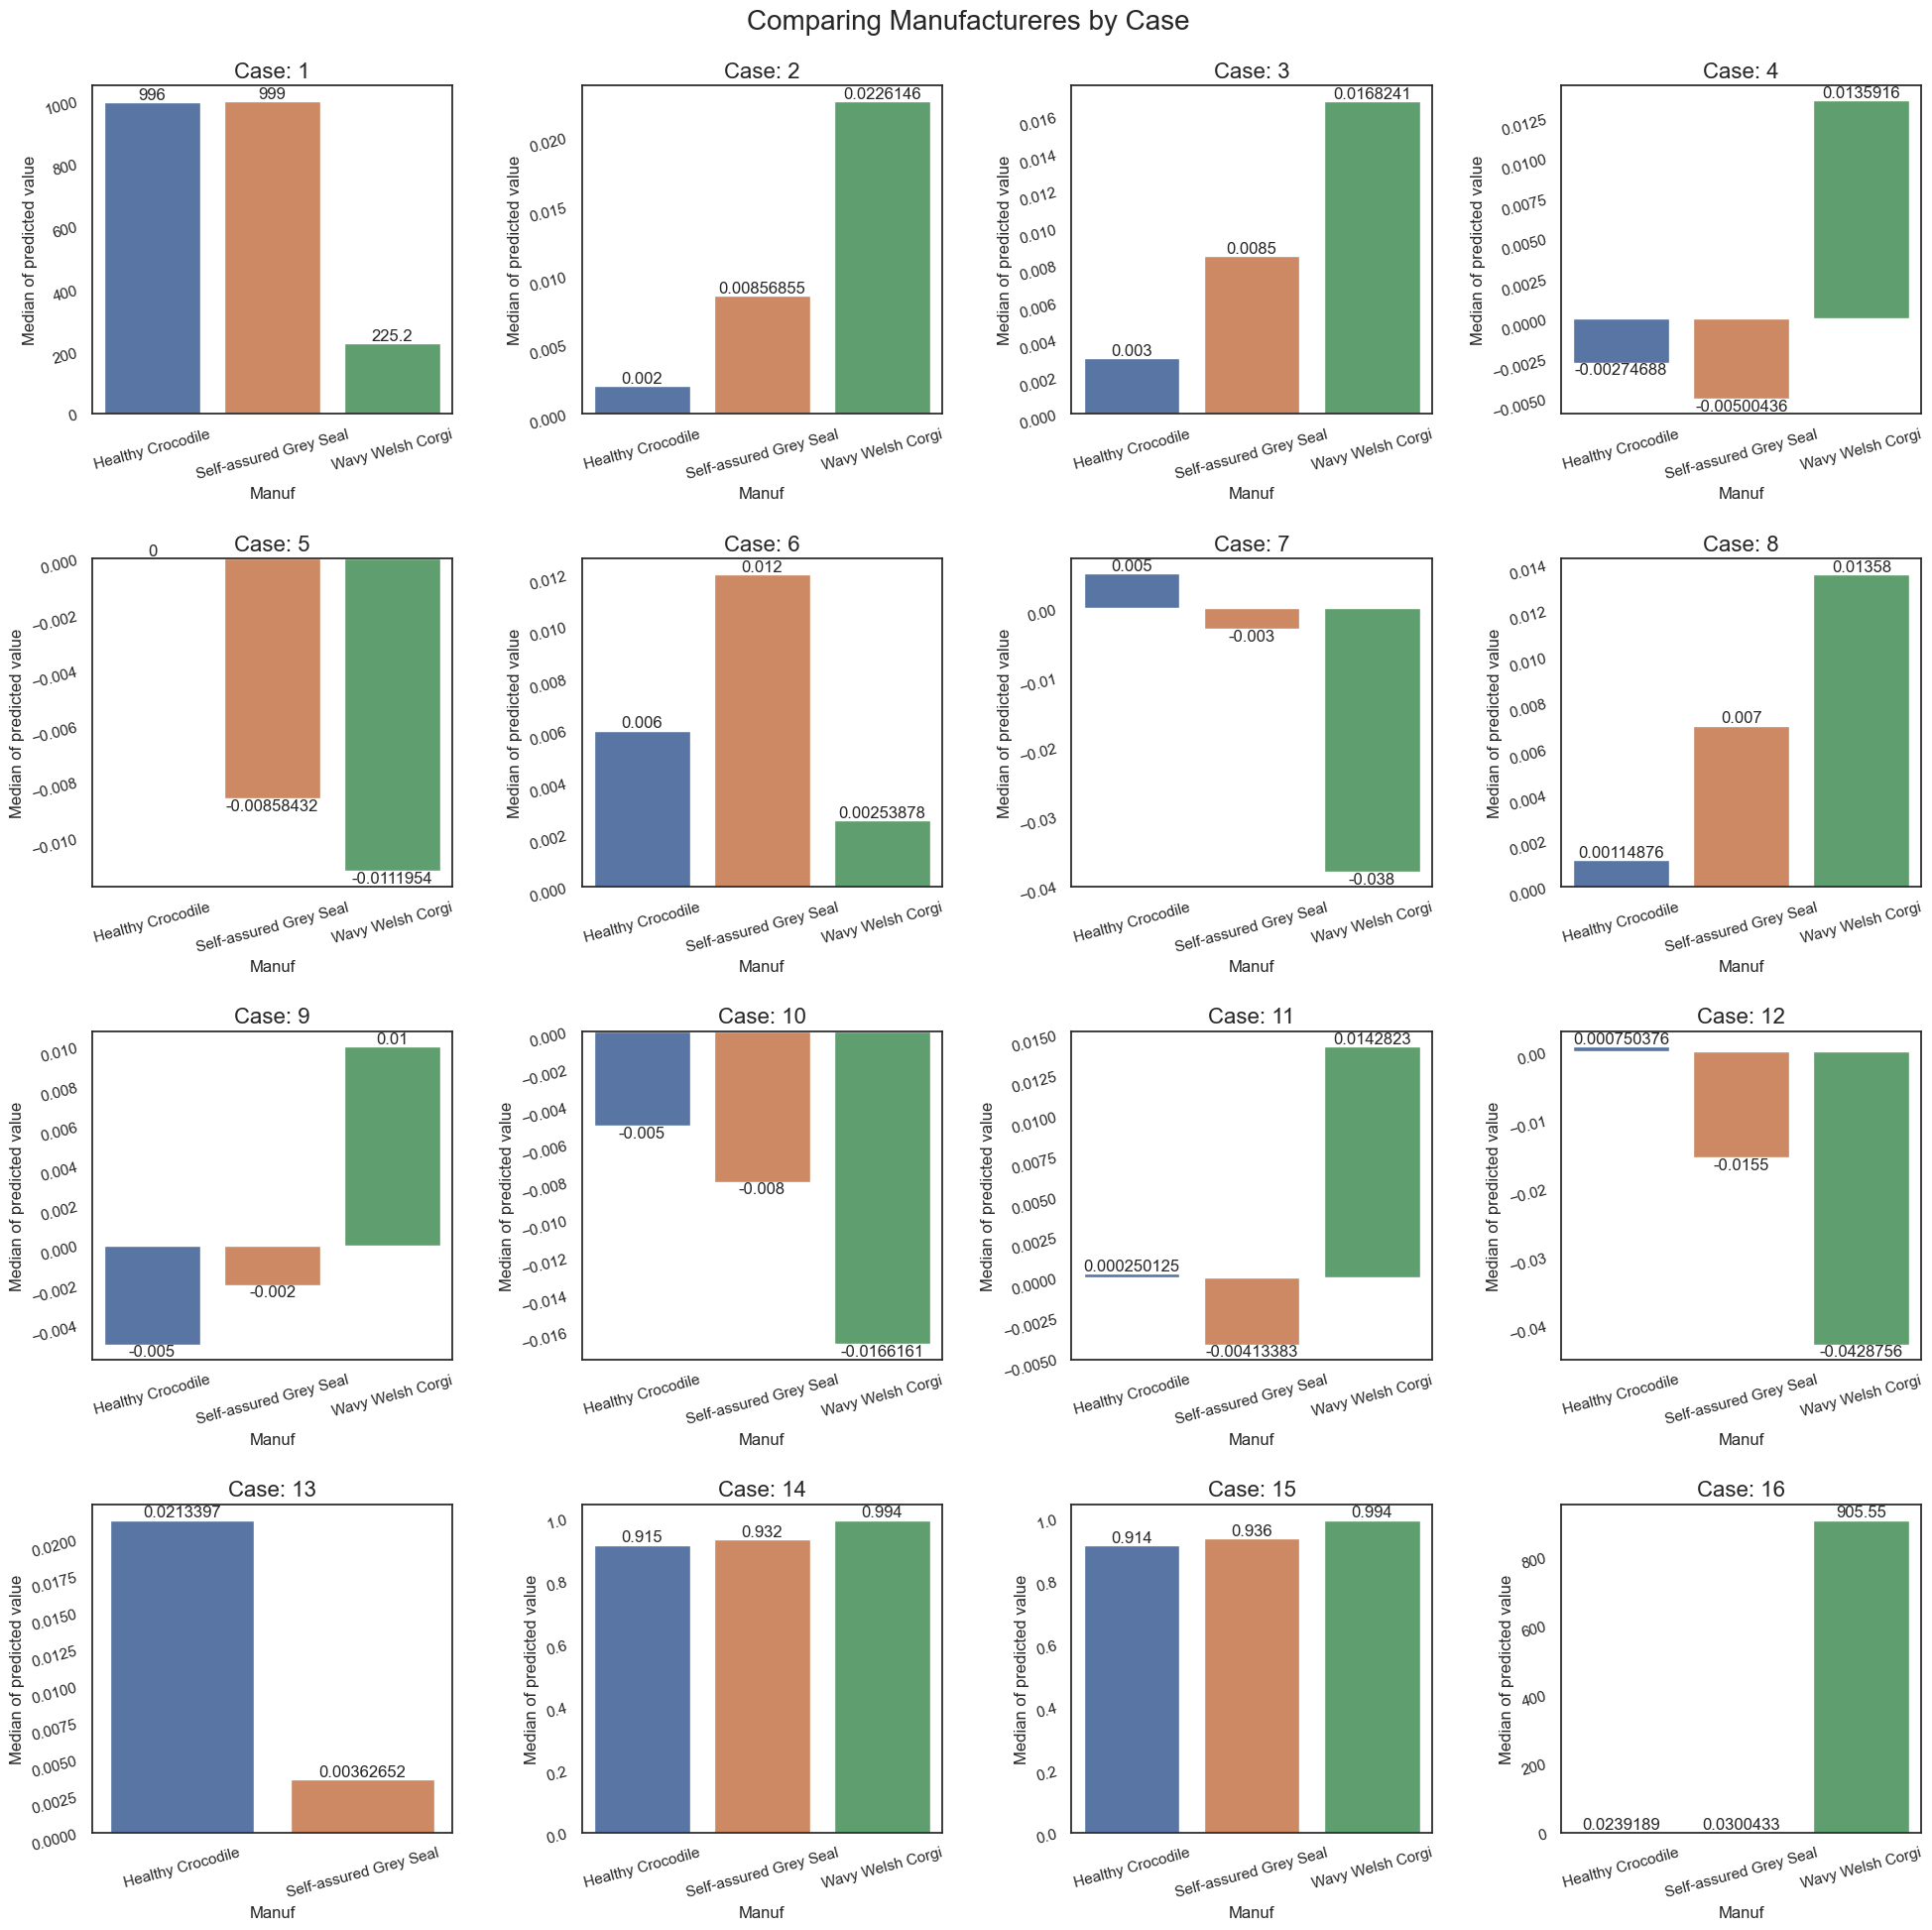

<Figure size 1500x800 with 0 Axes>

In [218]:
dfs = []
for case, new_df in per_case_manuf_values.groupby(level=0):
    dfs.append(new_df)
    
fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize = (20,20))

for index, data in enumerate(dfs):
    case = data.reset_index()["Case:"][0]
    
    clean_df = data.reset_index().drop(columns = 'Case:')
    manuf = clean_df["Manuf"].values
    
    col = index%4
    row = index//4
    
    plot = sns.barplot(data = clean_df, x = "Manuf", y = "predictedValue", ax = ax[row, col])
    plt.title(f"Case: {case}")
    ax[row,col].tick_params(labelrotation=15)
    ax[row,col].set_title(f"Case: {case}", size = 16)
    
    ax[row,col].bar_label(plot.containers[0])
    
    ax[row,col].set_ylabel("Median of predicted value")

fig.suptitle("Comparing Manufactureres by Case", size = 20)
fig.tight_layout(pad=2)

plt.show()
plt.savefig("Figures/Comparing_Manufacturers_by_Case.png")